### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Loading Data

In [2]:
data = pd.read_csv('segmentation data.csv')

In [3]:
#copying the original data
df = data.copy()

### Exploring the data

In [4]:
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [5]:
df.tail()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0
1999,100002000,0,0,25,0,68416,0,0


In [6]:
#checking the shape of dataframe
df.shape

(2000, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [8]:
#checking unique values
df.Sex.value_counts()

0    1086
1     914
Name: Sex, dtype: int64

0 - Male, 1 - Female

Out of 2000 customers, 1086 are male and 914 are female.

In [9]:
df['Marital status'].value_counts()

0    1007
1     993
Name: Marital status, dtype: int64

0 - Single
1 - non-single (divorced / separated / married / widowed)	


Marital status of 1007 out of 2000 customers is single, 993 of them are married

In [10]:
df.Education.value_counts()

1    1386
2     291
0     287
3      36
Name: Education, dtype: int64

0 - other/unknown

1 - high school

2 - university

3 - graduate school

36 out of 2000 customers are grad school graduates, 287 are have unknown education, 291 are university graduates, 1386 are high school graduates.

In [11]:
df.Occupation.value_counts()

1    1113
0     633
2     254
Name: Occupation, dtype: int64

0 - unemployed/unskilled

1 - skilled employee/official

2 - management/self-employed/highly qualified employee/officer



In [12]:
df['Settlement size'].value_counts()

0    989
1    544
2    467
Name: Settlement size, dtype: int64

0 - small city

1 - mid-sized city

2 - big city

In [13]:
#dropping the Id column as it is of no use
df.drop('ID',axis = 1, inplace = True)

In [14]:
#checking the summary statistics of columns
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Age values range in between 18 and 76

Income varies between 35832 and 309364

### Preprocessing and visualising

In [15]:
#checking for missing values
df.isnull().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

No missing values

---

In [16]:
#Separating categorical and numerical features
cat_features = ['Sex','Marital status','Education','Occupation','Settlement size']
num_features = ['Age','Income']

Examining the distribution of numerical features

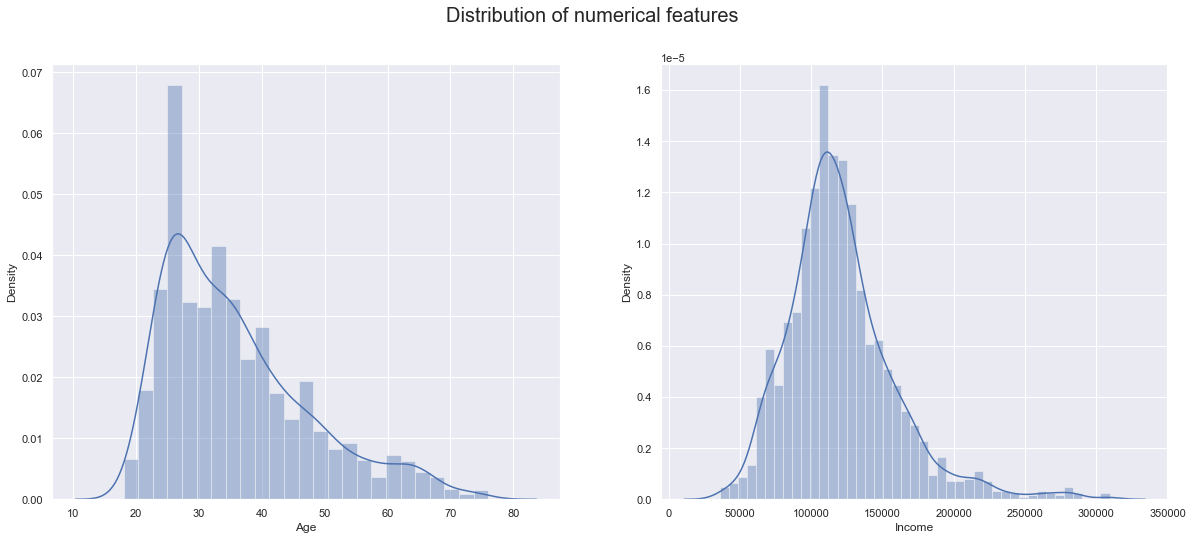

In [17]:
plt.rcParams['figure.figsize']=(20,8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
plt.suptitle('Distribution of numerical features',size = 20)
sns.distplot(x = df['Age'],ax = ax[0],axlabel = 'Age')
sns.distplot(x = df['Income'], ax = ax[1],axlabel = 'Income')
plt.show()

As we can see, Income variable follows a normal distribution very closely as opposed to Age column which is slightly skewed towards lower values

---

Checking for outliers

We define outliers as the values lying 1.5 * IQR left of the 1st quartile and 1.5 * IQR right of the 3rd quartile

In [18]:
#checking for the presence of outliers
for num_col in num_features:
    q1 = df[num_col].quantile(0.25) #first quartile
    q3 = df[num_col].quantile(0.75) #3rd quartile
    
    #calculating inter-quartile range
    IQR = q3-q1
    
    #setting upper and lower bounds
    upper = q3 + 1.5*IQR
    lower = q1 - 1.5*IQR
    
    #checking if there is any value beyond the upper and lower bounds
    if df[(df[num_col] > upper) | (df[num_col] < lower)].any(axis = None):
        print(num_col, ': Yes')
        
    else:
        print(num_col, ': No')

Age : Yes
Income : Yes


We confirm that there are outliers in our data and must be dealt with accordingly

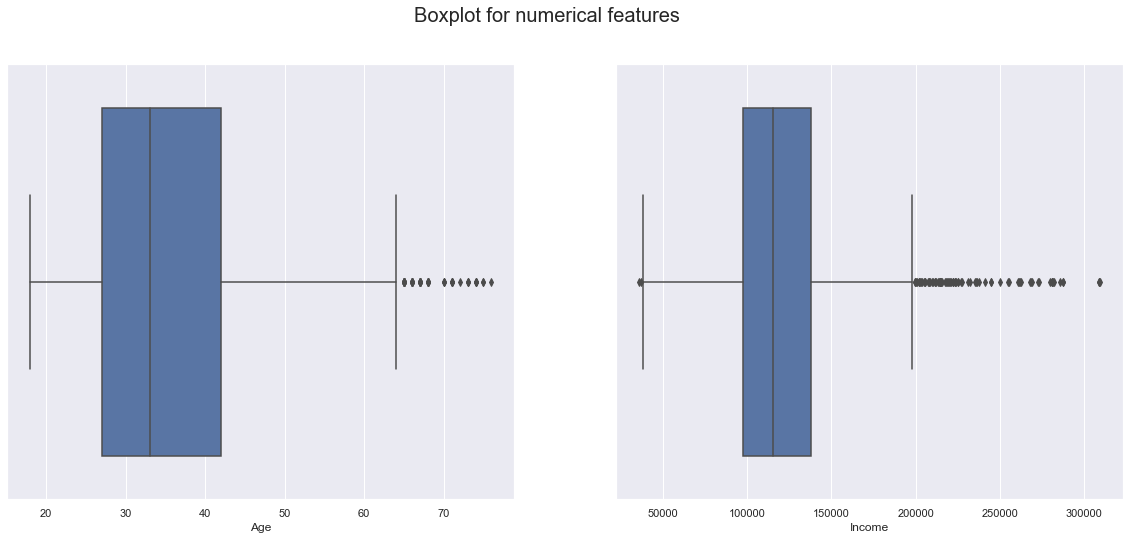

In [19]:
#creating boxplot to look at the outliers
plt.rcParams['figure.figsize']=(20,8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
plt.suptitle('Boxplot for numerical features',size = 20)
sns.boxplot(data = df, x = 'Age',ax = ax[0])
sns.boxplot(data = df, x = 'Income', ax = ax[1])
plt.show()

All the outliers lying beyond the upper limit will be set to upper limit and those lying beyond the lower limit will be set to lower limit

In [20]:
for num_col in num_features:
    q1 = df[num_col].quantile(0.25) #first quartile
    q3 = df[num_col].quantile(0.75) #3rd quartile
    
    #calculating inter-quartile range
    IQR = q3-q1
    
    #setting upper and lower bounds
    upper = q3 + 1.5*IQR
    lower = q1 - 1.5*IQR
    
    df.loc[df[num_col] > upper, num_col] = upper
    df.loc[df[num_col] < lower, num_col] = lower

In [21]:
#again checking for outliers
for num_col in num_features:
    q1 = df[num_col].quantile(0.25) #first quartile
    q3 = df[num_col].quantile(0.75) #3rd quartile
    
    #calculating inter-quartile range
    IQR = q3-q1
    
    #setting upper and lower bounds
    upper = q3 + 1.5*IQR
    lower = q1 - 1.5*IQR
    
    #checking if there is any value beyond the upper and lower bounds
    if df[(df[num_col] > upper) | (df[num_col] < lower)].any(axis = None):
        print(num_col, ': Yes')
        
    else:
        print(num_col, ': No')

Age : No
Income : No


No more outliers

In [22]:
#checking the summary statistics
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.798250,1.03800,119501.931625,0.810500,0.739000
std,0.498272,0.500113,11.413394,0.59978,33693.203903,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,37049.750000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,64.500000,3.00000,198685.750000,2.000000,2.000000


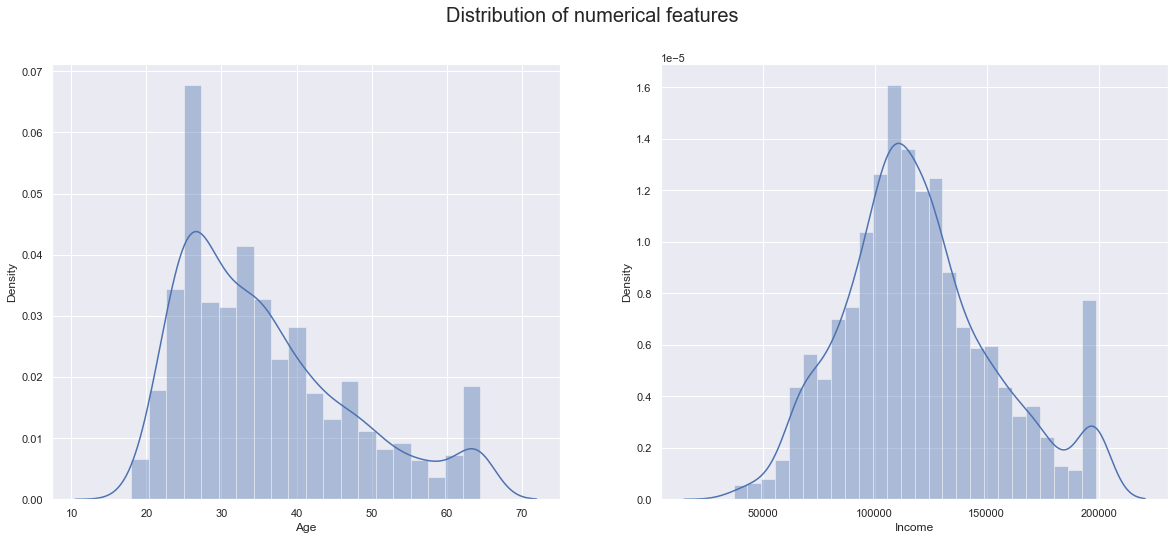

In [23]:
#checking Age and income distributions after outlier removal
plt.rcParams['figure.figsize']=(20,8)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
plt.suptitle('Distribution of numerical features',size = 20)
sns.distplot(x = df['Age'],ax = ax[0],axlabel = 'Age')
sns.distplot(x = df['Income'], ax = ax[1],axlabel = 'Income')
plt.show()

Incom resembles normal distribution very closely but the multiple peaks in both distributions hint towards separate clusters

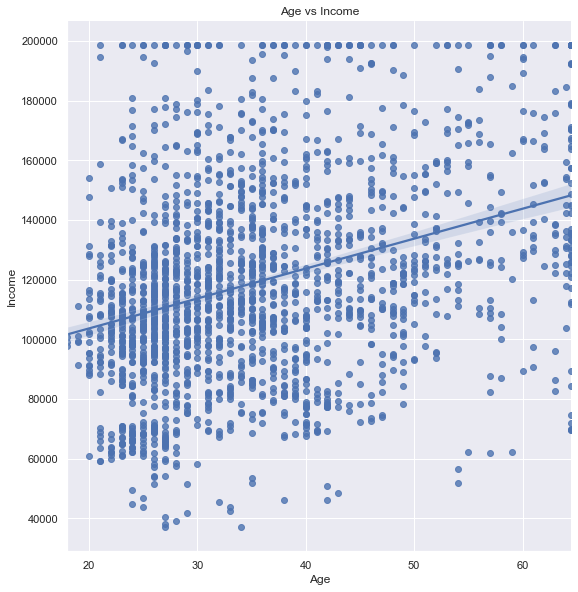

In [24]:
#checking the age vs income distribution
sns.lmplot(data = df, x = 'Age', y = 'Income',size = 8)
plt.title('Age vs Income')
plt.show()

Some positive correlation can be observed

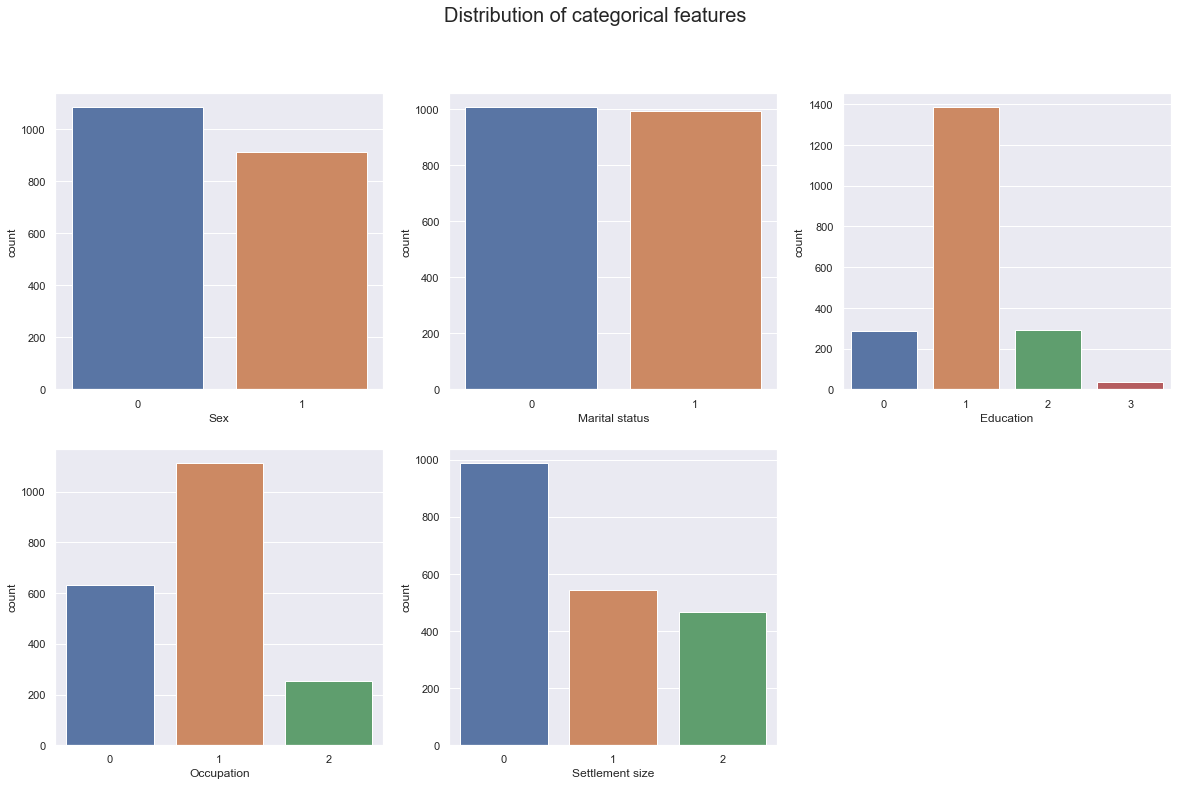

In [25]:
#creating countplots for all the categorical features
plt.rcParams['figure.figsize']=(20,12)
fig, ax = plt.subplots(nrows = 2, ncols = 3)
plt.suptitle('Distribution of categorical features',size = 20)
for col, axes in zip(cat_features, ax.flat[:len(cat_features)]):
    sns.countplot(data = df, x = col,ax = axes)
    
fig.delaxes(ax[1,2])

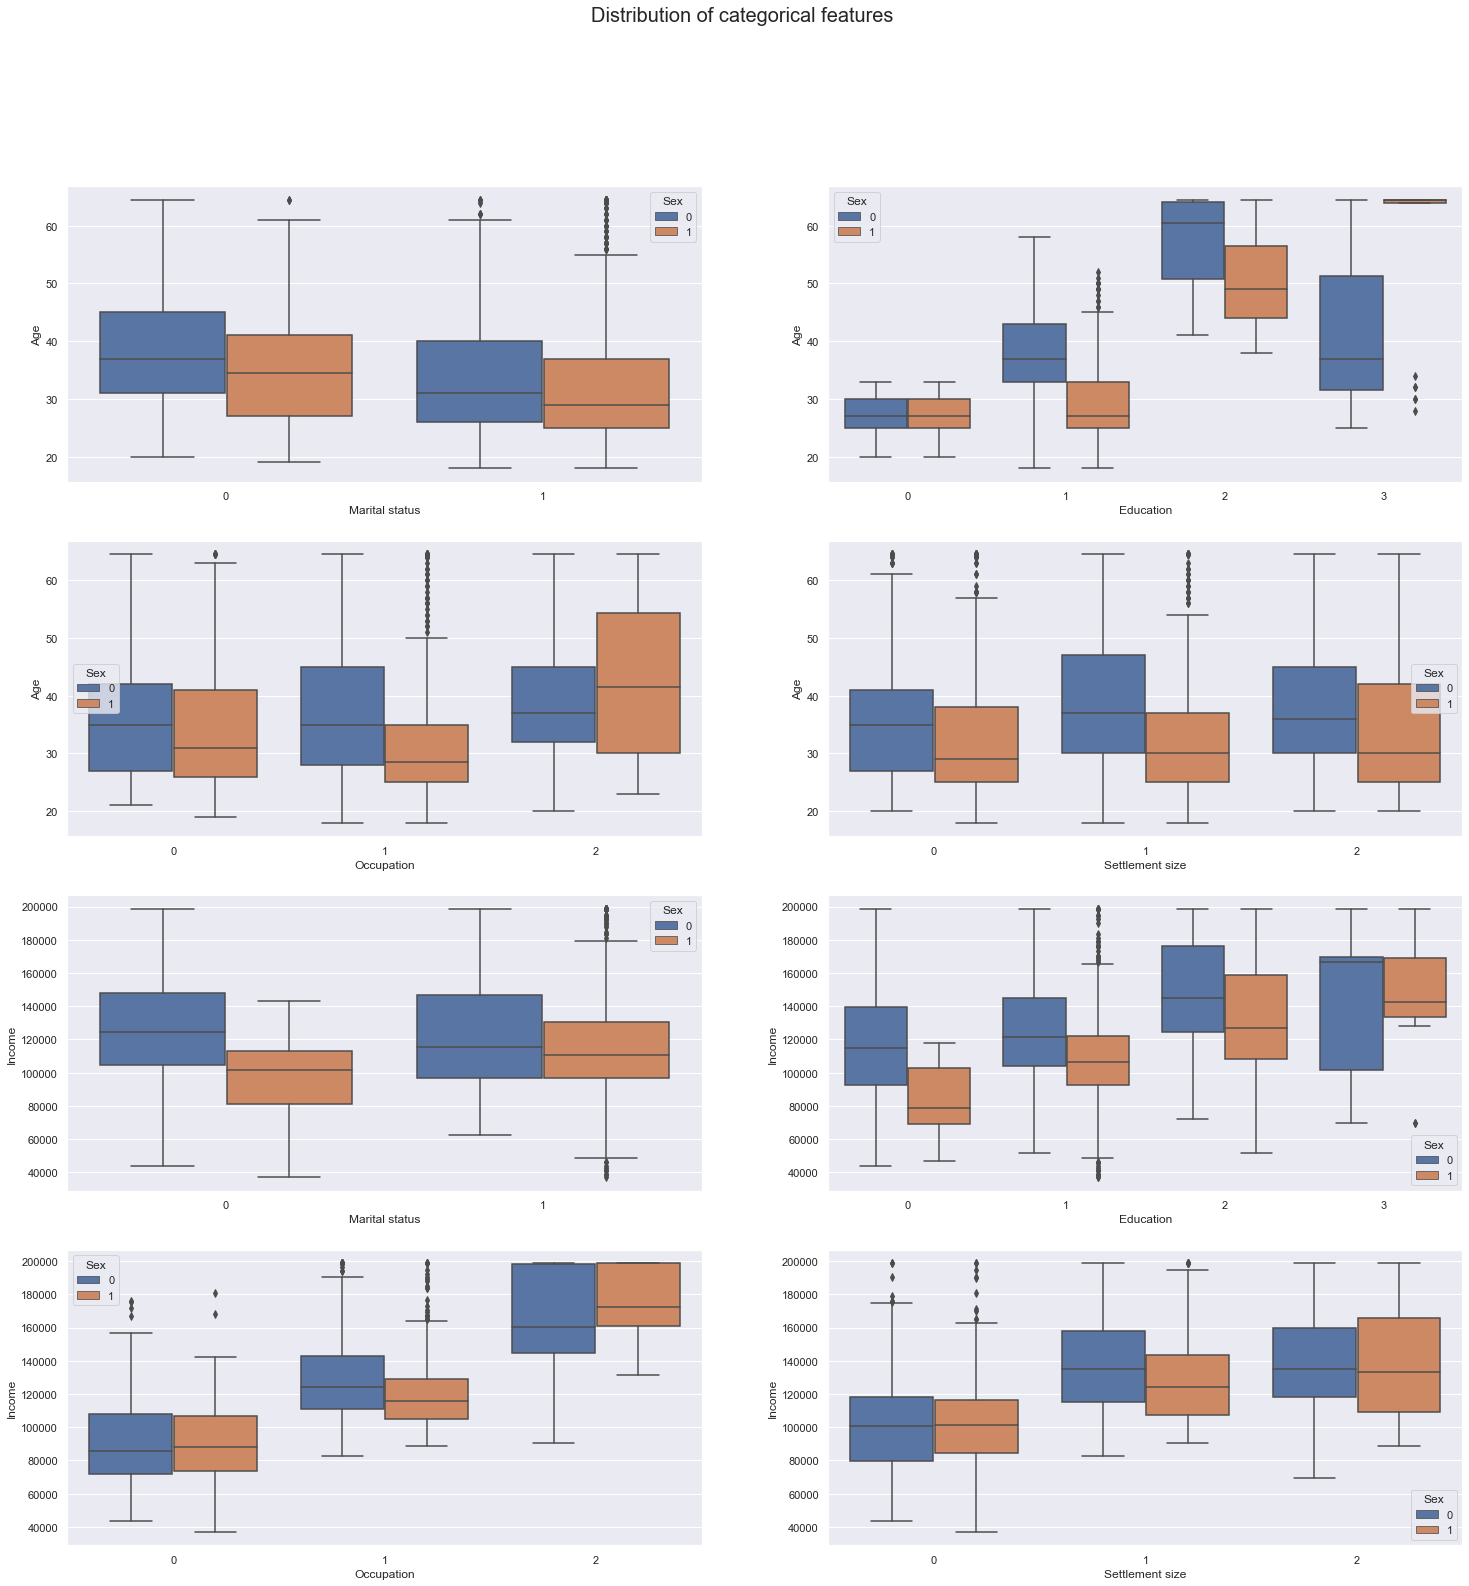

In [26]:
#checking the distribution of categorical features against age and income columns using boxplots
plt.rcParams['figure.figsize']=(25,25)
fig, ax = plt.subplots(nrows = 4, ncols = 2)
plt.suptitle('Distribution of categorical features',size = 20)
for col, axes in zip(cat_features[1:], ax.flat[:len(cat_features)]):
    sns.boxplot(data = df, x = col,y = 'Age',ax = axes, hue = 'Sex')

for col, axes in zip(cat_features[1:], ax.flat[len(cat_features)-1:]):
    sns.boxplot(data = df, x = col,y = 'Income',ax = axes, hue = 'Sex')

Checking for correlation

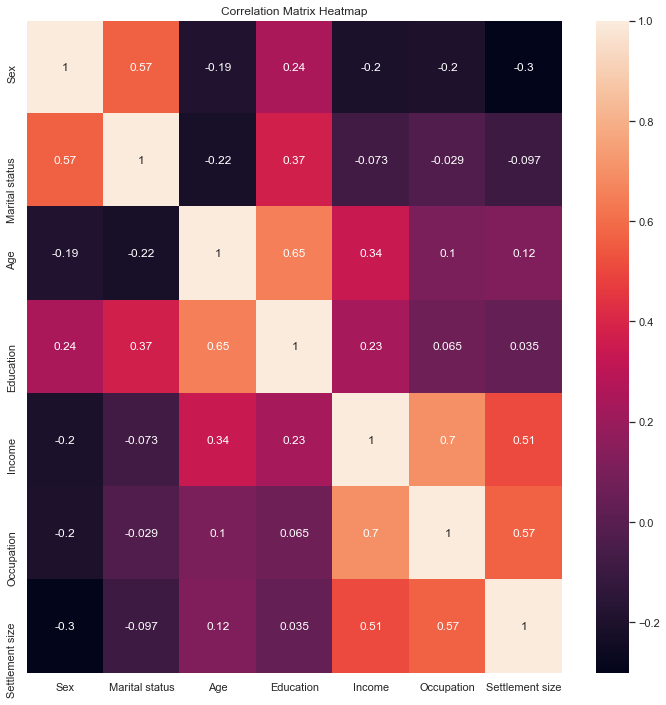

In [27]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation Matrix Heatmap')
plt.show()

Income and occupation have a 0.7 correlation which is to be expected

Also, Education and Age have a 0.65 correlation which is expected as well

Otherwise, no significant correlation

### K-Means Clustering

In [28]:
kmeans = KMeans()

In [29]:
clusters = kmeans.fit(X = df)

In [30]:
#finding the optimal number of clusters
scores = []
for i in range(2,21):
    kmeans = KMeans(n_clusters = i)
    clusters = kmeans.fit(df)
    scores.append(kmeans.inertia_)
    i = i+1

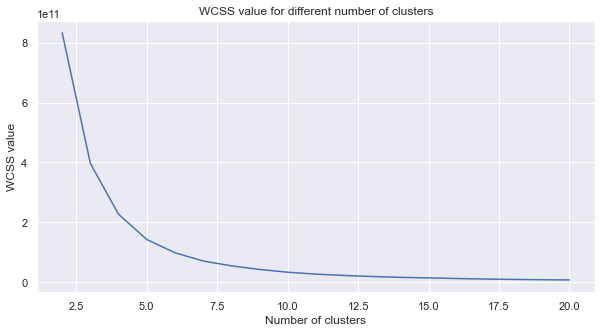

In [31]:
#visualising the results
plt.figure(figsize = (10,5))
plt.plot(range(2,21),scores)
plt.title('WCSS value for different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS value')
plt.show()

From here it looks like optimal number of clusters must be 3,4 or 5 


---

Using KElbowVisualizer of yellowbrick 

In [32]:
from yellowbrick.cluster import KElbowVisualizer

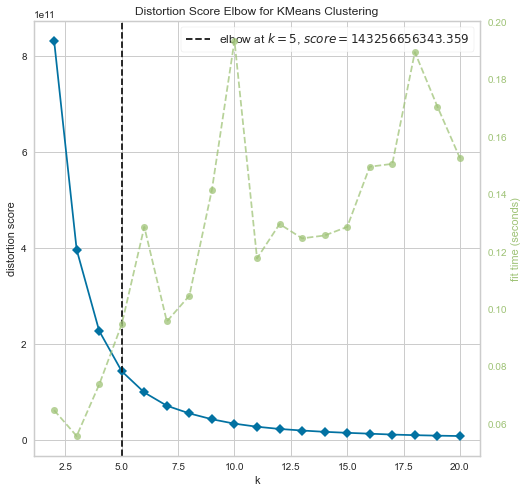

In [33]:
kmeans = KMeans()
plt.figure(figsize = (8,8))
vis = KElbowVisualizer(kmeans,k = (2,21))
vis.fit(df)
vis.poof()
plt.show()

Since the age and income columns vary greatly in magnitudes, we shall standardize these and again check for optimal clusters

In [34]:
df_std = StandardScaler().fit_transform(df)

In [35]:
df_std.shape

(2000, 7)

In [36]:
df_std = pd.DataFrame(data = df_std, columns = df.columns)
df_std.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,-0.917399,-0.993024,2.515372,1.604323,0.153424,0.296823,1.552326
1,1.090038,1.007025,-1.209255,-0.063372,0.928344,0.296823,1.552326
2,-0.917399,-0.993024,1.156979,-0.063372,-0.899277,-1.269525,-0.909730
3,-0.917399,-0.993024,0.806425,-0.063372,1.545596,0.296823,0.321298
4,-0.917399,-0.993024,1.507532,-0.063372,0.876629,0.296823,0.321298


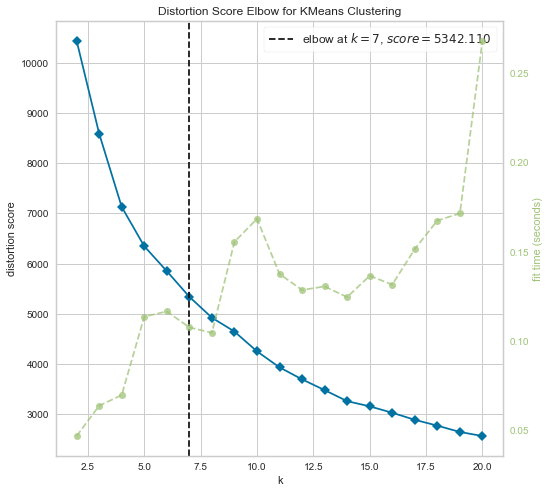

In [37]:
kmeans = KMeans()
plt.figure(figsize = (8,8))
vis = KElbowVisualizer(kmeans, k = (2,21))
vis.fit(df_std)
vis.poof()
plt.show()

In [38]:
#trying with 5 clusters on non-standardised data
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X = df)
cluster = kmeans.labels_

#adding a column in the dataframe with predicted labels
df['Cluster label KMeans'] = cluster

In [39]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster label KMeans
0,0,0,64.5,2,124670.0,1,2,0
1,1,1,22.0,1,150773.0,1,2,4
2,0,0,49.0,1,89210.0,0,0,3
3,0,0,45.0,1,171565.0,1,1,4
4,0,0,53.0,1,149031.0,1,1,4


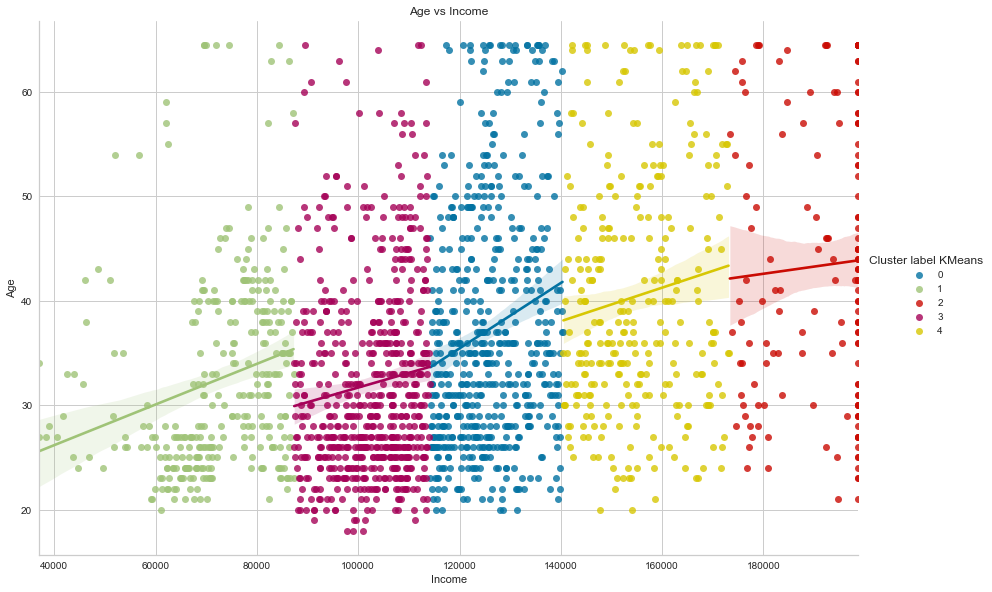

In [40]:
#let's check the age vs income distribution
sns.lmplot(data = df, y = 'Age', x = 'Income',size = 8, aspect = 1.5 , hue = 'Cluster label KMeans')
plt.title('Age vs Income')
plt.show()

In [41]:
# looking at the standardized results
#trying with 7 clusters
kmeans = KMeans(n_clusters = 7)
kmeans.fit(X = df_std)
cluster = kmeans.labels_

#adding a column in the dataframe with predicted labels
df_std['Cluster label KMeans'] = cluster

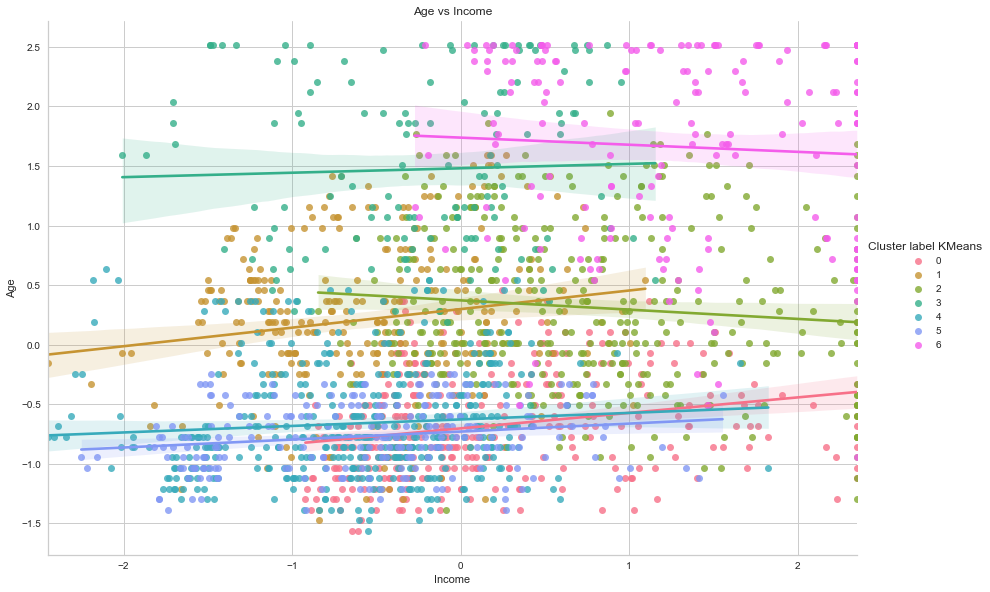

In [42]:
#let's check the age vs income distribution
sns.lmplot(data = df_std, y = 'Age', x = 'Income',size = 8, aspect = 1.5 , hue = 'Cluster label KMeans')
plt.title('Age vs Income')
plt.show()

Trying out Birch Algorithm

In [43]:
from sklearn.cluster import Birch

In [44]:
model = Birch(threshold = 0.01, n_clusters = 5)

#fit model and predict clusters
model.fit(df)
labels = model.predict(df)

In [45]:
#adding in the dataframe
df['Birch Clusters'] = labels
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster label KMeans,Birch Clusters
0,0,0,64.5,2,124670.0,1,2,0,2
1,1,1,22.0,1,150773.0,1,2,4,3
2,0,0,49.0,1,89210.0,0,0,3,1
3,0,0,45.0,1,171565.0,1,1,4,0
4,0,0,53.0,1,149031.0,1,1,4,3


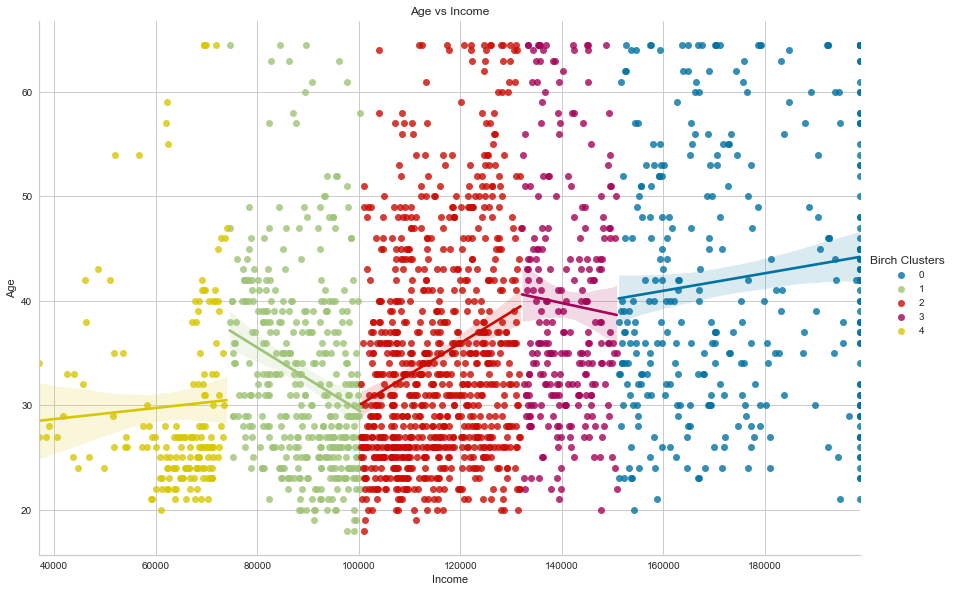

In [46]:
#let's check the age vs income distribution
sns.lmplot(data = df, y = 'Age', x = 'Income',size = 8, aspect = 1.5 , hue = 'Birch Clusters')
plt.title('Age vs Income')
plt.show()

Looking at how Gaussian mixture model performs

In [47]:
from sklearn.mixture import GaussianMixture

In [48]:
gm = GaussianMixture(n_components = 5)
gm.fit(df)
y_pred = gm.predict(df)

In [49]:
#looking at the clusters
df['Gaussian'] = y_pred
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster label KMeans,Birch Clusters,Gaussian
0,0,0,64.5,2,124670.0,1,2,0,2,0
1,1,1,22.0,1,150773.0,1,2,4,3,4
2,0,0,49.0,1,89210.0,0,0,3,1,3
3,0,0,45.0,1,171565.0,1,1,4,0,4
4,0,0,53.0,1,149031.0,1,1,4,3,4


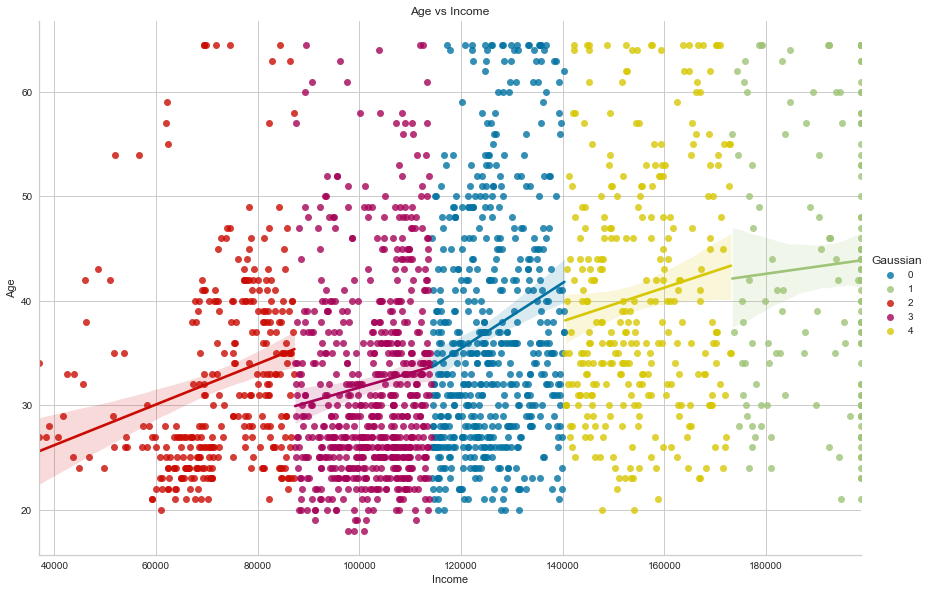

In [50]:
#let's check the age vs income distribution
sns.lmplot(data = df, y = 'Age', x = 'Income',size = 8, aspect = 1.5 , hue = 'Gaussian')
plt.title('Age vs Income')
plt.show()

### Comparing outputs of different clustering algorithms using Rand Index and Adjusted Rand Index

In [51]:
from sklearn.metrics import adjusted_rand_score, rand_score

In [52]:
# comparing K-means and Birch algorithms
rs = rand_score(df['Cluster label KMeans'],df['Birch Clusters'])
ars = adjusted_rand_score(df['Cluster label KMeans'],df['Birch Clusters'])

print('Rand Score for KMeans and Birch algorithm: ',rs)
print('Adjusted Rand Score for KMeans and Birch algorithm: ',ars)

Rand Score for KMeans and Birch algorithm:  0.768855427713857
Adjusted Rand Score for KMeans and Birch algorithm:  0.3904648915903672


In [53]:
#comparing KMeans and Gaussian Mixture Models
rs1 = rand_score(df['Cluster label KMeans'],df['Gaussian'])
ars1 = adjusted_rand_score(df['Cluster label KMeans'],df['Gaussian'])

print('Rand Score for KMeans and Gaussian algorithm: ',rs1)
print('Adjusted Rand Score for KMeans and Gaussian algorithm: ',ars1)

Rand Score for KMeans and Gaussian algorithm:  1.0
Adjusted Rand Score for KMeans and Gaussian algorithm:  1.0


This suggests that we get exactly the same clusters by both KMeans and Gaussian mixture models

### Calculating Silhouette coefficient for all models

In [55]:
from sklearn.metrics import silhouette_score

features = cat_features + num_features
features

['Sex',
 'Marital status',
 'Education',
 'Occupation',
 'Settlement size',
 'Age',
 'Income']

In [57]:
#for KMeans Algorithm
ss_kmeans = silhouette_score(df[features],df['Cluster label KMeans'])
ss_kmeans

0.5494638872551718

In [58]:
#for Birch Algorithm
ss_birch = silhouette_score(df[features],df['Birch Clusters'])
ss_birch

0.4602094515681667

In [59]:
#for Gaussian mixture model
ss_gaussian = silhouette_score(df[features],df['Gaussian'])
ss_gaussian

0.5494638872551718

All algorithms have a score of around 0.5 which suggests that while the clusters generated are not well apart but they are not overlapping either

### Hierarchial Clustering

In [244]:
import scipy.cluster.hierarchy as sch

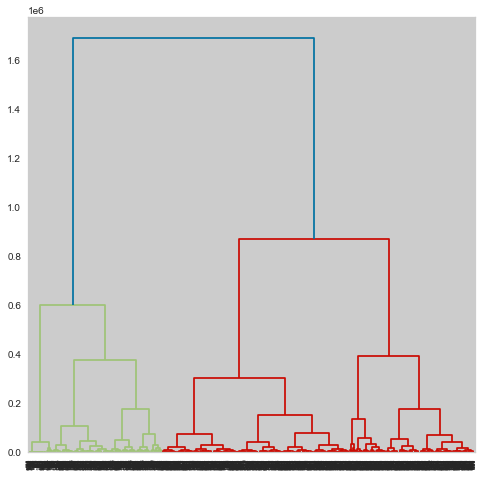

In [245]:
plt.figure(figsize = (8,8))
dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
plt.show()

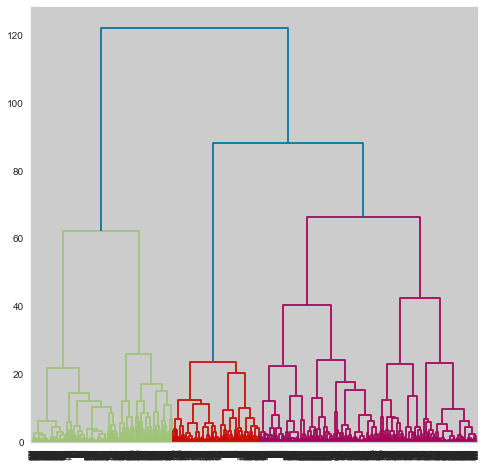

In [247]:
#what happens after standardization
plt.figure(figsize = (8,8))
dendrogram = sch.dendrogram(sch.linkage(df_std, method = 'ward'))
plt.show()